# ORF recognition by LSTM
LSTM was incapable of ORF recognition on 1000 bp sequences. Try smaller.


In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-18 11:28:50 UTC'

In [2]:
PC_SEQUENCES=20000   # how many protein-coding sequences
NC_SEQUENCES=20000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
BASES=100            # how long is each sequence
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (BASES,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (BASES,ALPHABET) # Conv1D needs 2D inputs
NEURONS = 32
#DROP_RATE = 0.2
EPOCHS=50  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=5  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import *
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import LSTM
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    pcgen.set_seq_oracle(Transcript_Oracle())
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen
def get_the_facts(seqs):
    rd = RNA_describer()
    facts = rd.get_three_lengths(seqs)
    facts_ary = np.asarray(facts) # 5000 rows, 3 columns 
    print("Facts array:",type(facts_ary))
    print("Facts array:",facts_ary.shape)
    # Get the mean of each column
    mean_5utr, mean_orf, mean_3utr = np.mean(facts_ary,axis=0)
    std_5utr, std_orf, std_3utr = np.std(facts_ary,axis=0)
    print("mean 5' UTR length:",int(mean_5utr),"+/-",int(std_5utr))
    print("mean    ORF length:",int(mean_orf), "+/-",int(std_orf))
    print("mean 3' UTR length:",int(mean_3utr),"+/-",int(std_3utr))

pc_sim,nc_sim = make_generators(BASES)
pc_train = pc_sim.get_sequences(PC_SEQUENCES)
nc_train = nc_sim.get_sequences(NC_SEQUENCES)
print("Train on",len(pc_train),"PC seqs")
get_the_facts(pc_train)
print("Train on",len(nc_train),"NC seqs")
get_the_facts(nc_train)

Train on 20000 PC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 23 +/- 7
mean    ORF length: 51 +/- 10
mean 3' UTR length: 25 +/- 5
Train on 20000 NC seqs
Facts array: <class 'numpy.ndarray'>
Facts array: (20000, 3)
mean 5' UTR length: 40 +/- 18
mean    ORF length: 17 +/- 22
mean 3' UTR length: 42 +/- 18


In [6]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [7]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=ALPHABET, output_dim=ALPHABET))
        #VOCABULARY_SIZE, EMBED_DIMEN, input_length=1000, input_length=1000, mask_zero=True)
        #input_dim=[None,VOCABULARY_SIZE], output_dim=EMBED_DIMEN, mask_zero=True)
    dnn.add(LSTM(NEURONS,return_sequences=True,input_shape=INPUT_SHAPE))
    dnn.add(LSTM(NEURONS,return_sequences=False)) 
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build() # input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (100, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 32)           4736      
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 26s 9ms/step - loss: 0.6841 - accuracy: 0.5423 - val_loss: 0.6620 - val_accuracy: 0.6053


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6535 - accuracy: 0.6205 - val_loss: 0.6269 - val_accuracy: 0.6515


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6175 - accuracy: 0.6564 - val_loss: 0.6061 - val_accuracy: 0.6600


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5993 - accuracy: 0.6709 - val_loss: 0.5754 - val_accuracy: 0.6892


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 5/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5700 - accuracy: 0.6918 - val_loss: 0.5589 - val_accuracy: 0.7028


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 6/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5521 - accuracy: 0.7080 - val_loss: 0.5406 - val_accuracy: 0.7096


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 7/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5358 - accuracy: 0.7191 - val_loss: 0.5388 - val_accuracy: 0.7099


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 8/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5314 - accuracy: 0.7152 - val_loss: 0.5287 - val_accuracy: 0.7180


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 9/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5209 - accuracy: 0.7322 - val_loss: 0.5225 - val_accuracy: 0.7284


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 10/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5104 - accuracy: 0.7396 - val_loss: 0.5030 - val_accuracy: 0.7495


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 11/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4899 - accuracy: 0.7592 - val_loss: 0.4190 - val_accuracy: 0.8158


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 12/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3851 - accuracy: 0.8349 - val_loss: 0.2898 - val_accuracy: 0.8898


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 13/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2821 - accuracy: 0.8915 - val_loss: 0.2823 - val_accuracy: 0.8866
Epoch 14/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3770 - accuracy: 0.8008 - val_loss: 0.6938 - val_accuracy: 0.4933
Epoch 15/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6928 - accuracy: 0.5106 - val_loss: 0.5720 - val_accuracy: 0.6875
Epoch 16/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5406 - accuracy: 0.7131 - val_loss: 0.5301 - val_accuracy: 0.7169
Epoch 17/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5027 - accuracy: 0.7391 - val_loss: 0.4312 - val_accuracy: 0.8096
Epoch 18/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3529 - accuracy: 0.8443 - val_loss: 0.2802 - val_accuracy: 0.8881
Epoch 19/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3053 - accuracy: 0.8804 - val_loss: 0.2686 - val_ac

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 20/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2808 - accuracy: 0.8960 - val_loss: 0.2618 - val_accuracy: 0.9010


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 21/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2419 - accuracy: 0.9088 - val_loss: 0.2912 - val_accuracy: 0.8841
Epoch 22/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2598 - accuracy: 0.9044 - val_loss: 0.2453 - val_accuracy: 0.9105


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 23/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2445 - accuracy: 0.9091 - val_loss: 0.2455 - val_accuracy: 0.9109


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 24/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2357 - accuracy: 0.9105 - val_loss: 0.2491 - val_accuracy: 0.9084
Epoch 25/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2399 - accuracy: 0.9097 - val_loss: 0.2432 - val_accuracy: 0.9095
Epoch 26/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2574 - accuracy: 0.9023 - val_loss: 0.2367 - val_accuracy: 0.9144


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 27/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2435 - accuracy: 0.9121 - val_loss: 0.2641 - val_accuracy: 0.9036
Epoch 28/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2466 - accuracy: 0.9098 - val_loss: 0.2225 - val_accuracy: 0.9230


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 29/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2206 - accuracy: 0.9190 - val_loss: 0.2143 - val_accuracy: 0.9210
Epoch 30/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2048 - accuracy: 0.9252 - val_loss: 0.2199 - val_accuracy: 0.9214
Epoch 31/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2111 - accuracy: 0.9244 - val_loss: 0.2147 - val_accuracy: 0.9224
Epoch 32/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2080 - accuracy: 0.9250 - val_loss: 0.2215 - val_accuracy: 0.9205
Epoch 33/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2134 - accuracy: 0.9213 - val_loss: 0.2047 - val_accuracy: 0.9295


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1978 - accuracy: 0.9291 - val_loss: 0.2100 - val_accuracy: 0.9226
Epoch 35/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1919 - accuracy: 0.9315 - val_loss: 0.2011 - val_accuracy: 0.9309


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 36/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1809 - accuracy: 0.9378 - val_loss: 0.2127 - val_accuracy: 0.9247
Epoch 37/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1826 - accuracy: 0.9367 - val_loss: 0.1988 - val_accuracy: 0.9302
Epoch 38/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1822 - accuracy: 0.9356 - val_loss: 0.1965 - val_accuracy: 0.9317


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2098 - accuracy: 0.9266 - val_loss: 0.1824 - val_accuracy: 0.9388


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 40/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1733 - accuracy: 0.9408 - val_loss: 0.2115 - val_accuracy: 0.9216
Epoch 41/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1805 - accuracy: 0.9377 - val_loss: 0.1945 - val_accuracy: 0.9331
Epoch 42/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1723 - accuracy: 0.9414 - val_loss: 0.1752 - val_accuracy: 0.9431


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 43/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1612 - accuracy: 0.9457 - val_loss: 0.1928 - val_accuracy: 0.9319
Epoch 44/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1605 - accuracy: 0.9447 - val_loss: 0.3015 - val_accuracy: 0.8957
Epoch 45/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2116 - accuracy: 0.9251 - val_loss: 0.1626 - val_accuracy: 0.9473


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1563 - accuracy: 0.9480 - val_loss: 0.1783 - val_accuracy: 0.9441
Epoch 47/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1597 - accuracy: 0.9486 - val_loss: 0.1541 - val_accuracy: 0.9517


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 48/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1563 - accuracy: 0.9486 - val_loss: 0.1612 - val_accuracy: 0.9473
Epoch 49/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1480 - accuracy: 0.9529 - val_loss: 0.1903 - val_accuracy: 0.9342
Epoch 50/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1765 - accuracy: 0.9405 - val_loss: 0.1940 - val_accuracy: 0.9329
Fold 1, 50 epochs, 619 sec


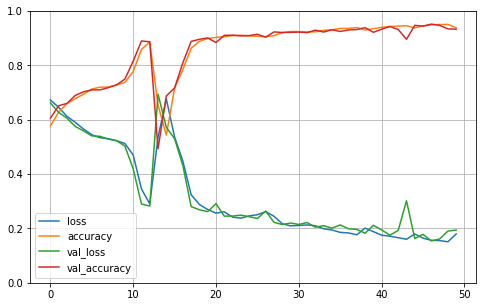

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.7019 - accuracy: 0.5033 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 2/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6935 - accuracy: 0.4984 - val_loss: 0.6946 - val_accuracy: 0.4995
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6938 - accuracy: 0.5004 - val_loss: 0.6958 - val_accuracy: 0.5005
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6940 - accuracy: 0.5036 - val_loss: 0.6936 - val_accuracy: 0.4995
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6936 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4951
Epoch 6/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6937 - accuracy: 0.5016 - val_loss: 0.6938 - val_accuracy: 0.4995
Epoch 7/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6937 - accuracy:

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 32/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1720 - accuracy: 0.9436 - val_loss: 0.1841 - val_accuracy: 0.9426
Epoch 33/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1740 - accuracy: 0.9440 - val_loss: 0.1514 - val_accuracy: 0.9534


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 34/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1754 - accuracy: 0.9433 - val_loss: 0.2407 - val_accuracy: 0.9194
Epoch 35/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1599 - accuracy: 0.9489 - val_loss: 0.1645 - val_accuracy: 0.9460
Epoch 36/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1695 - accuracy: 0.9455 - val_loss: 0.1481 - val_accuracy: 0.9505
Epoch 37/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1515 - accuracy: 0.9496 - val_loss: 0.1740 - val_accuracy: 0.9474
Epoch 38/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1618 - accuracy: 0.9462 - val_loss: 0.1471 - val_accuracy: 0.9535


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 39/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1563 - accuracy: 0.9488 - val_loss: 0.1775 - val_accuracy: 0.9395
Epoch 40/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1513 - accuracy: 0.9489 - val_loss: 0.1954 - val_accuracy: 0.9324
Epoch 41/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1589 - accuracy: 0.9479 - val_loss: 0.1439 - val_accuracy: 0.9529
Epoch 42/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1489 - accuracy: 0.9511 - val_loss: 0.1501 - val_accuracy: 0.9499
Epoch 43/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1489 - accuracy: 0.9522 - val_loss: 0.1547 - val_accuracy: 0.9503
Epoch 44/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1448 - accuracy: 0.9531 - val_loss: 0.1416 - val_accuracy: 0.9511
Epoch 45/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1462 - accuracy: 0.9514 - val_loss: 0.1381 - val_ac

INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 46/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1452 - accuracy: 0.9535 - val_loss: 0.1380 - val_accuracy: 0.9539
Epoch 47/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1404 - accuracy: 0.9547 - val_loss: 0.1590 - val_accuracy: 0.9449
Epoch 48/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2013 - accuracy: 0.9270 - val_loss: 0.1702 - val_accuracy: 0.9503
Epoch 49/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1645 - accuracy: 0.9502 - val_loss: 0.1248 - val_accuracy: 0.9609


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 50/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1294 - accuracy: 0.9589 - val_loss: 0.1339 - val_accuracy: 0.9585
Fold 2, 50 epochs, 464 sec


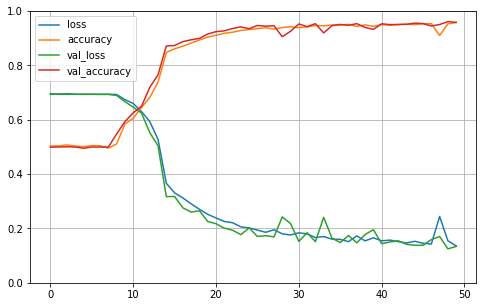

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.6831 - accuracy: 0.5549 - val_loss: 0.6604 - val_accuracy: 0.6036
Epoch 2/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6514 - accuracy: 0.6194 - val_loss: 0.6304 - val_accuracy: 0.6481
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6178 - accuracy: 0.6607 - val_loss: 0.5935 - val_accuracy: 0.6826
Epoch 4/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.5208 - accuracy: 0.7461 - val_loss: 0.3567 - val_accuracy: 0.8584
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3592 - accuracy: 0.8532 - val_loss: 0.3378 - val_accuracy: 0.8581
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3459 - accuracy: 0.8497 - val_loss: 0.3318 - val_accuracy: 0.8566
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3292 - accuracy:

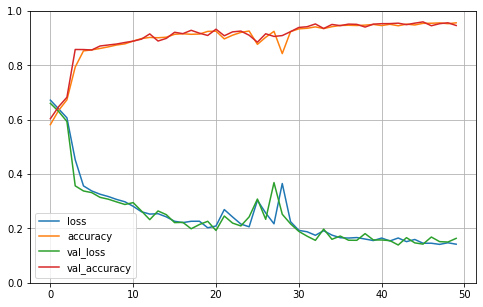

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 12s 9ms/step - loss: 0.6795 - accuracy: 0.5519 - val_loss: 0.6501 - val_accuracy: 0.6273
Epoch 2/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6407 - accuracy: 0.6363 - val_loss: 0.6172 - val_accuracy: 0.6566
Epoch 3/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6085 - accuracy: 0.6710 - val_loss: 0.4627 - val_accuracy: 0.7903
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.4047 - accuracy: 0.8347 - val_loss: 0.3383 - val_accuracy: 0.8566
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3471 - accuracy: 0.8570 - val_loss: 0.3357 - val_accuracy: 0.8630
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3353 - accuracy: 0.8611 - val_loss: 0.3315 - val_accuracy: 0.8618
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3405 - accuracy:

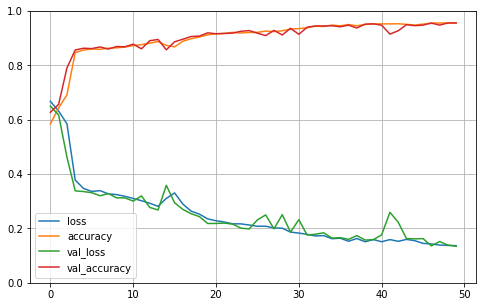

MODEL
make_DNN
input shape: (100, 4)
FIT
Epoch 1/50
1000/1000 [==============================] - 11s 9ms/step - loss: 0.6948 - accuracy: 0.5144 - val_loss: 0.6553 - val_accuracy: 0.6170
Epoch 2/50
1000/1000 [==============================] - 8s 8ms/step - loss: 0.6533 - accuracy: 0.6186 - val_loss: 0.6097 - val_accuracy: 0.6670
Epoch 3/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.6190 - accuracy: 0.6625 - val_loss: 0.5870 - val_accuracy: 0.6896
Epoch 4/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5992 - accuracy: 0.6815 - val_loss: 0.5894 - val_accuracy: 0.6935
Epoch 5/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.5534 - accuracy: 0.7189 - val_loss: 0.3651 - val_accuracy: 0.8515
Epoch 6/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3575 - accuracy: 0.8526 - val_loss: 0.3579 - val_accuracy: 0.8545
Epoch 7/50
1000/1000 [==============================] - 9s 9ms/step - loss: 0.3507 - accuracy:

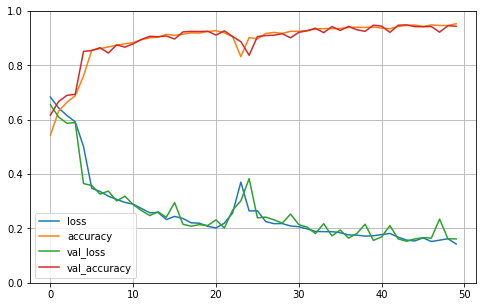

In [9]:
do_cross_validation(X,y)

In [10]:
from keras.models import load_model
pc_sim.set_reproducible(True)
nc_sim.set_reproducible(True)
pc_test = pc_sim.get_sequences(PC_TESTS)
nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 96.50%


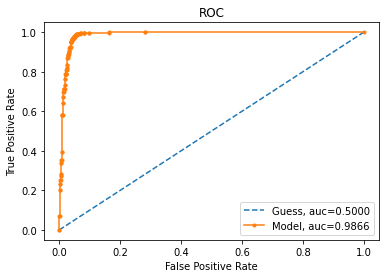

AUC: 0.99%


In [11]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc))


In [12]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-05-18 12:08:54 UTC'